# Code segmentation d'organes/ Passos Emanuelle et Ygé Nathan

# 1. Imports and Configurations

## 1.1 Imports

In [3]:
# Ce module regroupe les imports utiles pour la segmentation d'images.
# ==============================================================================


import os
import glob
import shutil
import math
import random
import numpy as np
import nibabel as nib
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy.spatial.distance import directed_hausdorff
from scipy.ndimage import distance_transform_edt as edt
from scipy.ndimage import binary_erosion
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

## 1.2 Configuration/ Hyperparameters

In [4]:
# Ce module regroupe la configuration et les constantes utiles pour 
# la segmentation d'images.
# ==============================================================================


# Détection automatique du GPU (CUDA) ou CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Périphérique utilisé : {DEVICE}")

# Paramètres des données
TARGET_SIZE = (384, 384)  # Taille des images en entrée du réseau
INPUT_CHANNELS = 1        # Nombre de canaux en entrée
OLD_VALUES = np.array([0., 80., 160., 240., 255.]) # Valeurs d'origine dans le masque NIfTI
NEW_VALUES = np.array([0, 1, 2, 3, 4]) # Nouvelles valeurs 
NUM_CLASSES = 5           # 0: Fond + 4 structures anatomiques
BATCH_SIZE = 4            # Nombre d'images par lot (Batch)

# Paramètres de découpage
NUM_TRAIN = 12
NUM_VAL = 4
NUM_TEST = 4
TOTAL_PATIENTS_EXPECTED = NUM_TRAIN + NUM_VAL + NUM_TEST

# Paramètres d'entraînement
LEARNING_RATE = 1e-4      # Vitesse d'apprentissage
N_EPOCHS = 40             # Nombre maximum d'époques
PATIENCE = 10             # Arrêt si pas d'amélioration après N époques  

Périphérique utilisé : cuda


# 2. Preprocessing

## 2.1 Loading Dataset

In [5]:
# Ce module charge le dataset et affiche des données concernant les classes
# présentes dans les masques NIfTI.
# ==============================================================================


# Chemin du fichier masque NIfTI
mask_file = 'D:/IMT/MCE/Deep Learning/project/MR-dataset/01-T2SPIR-mask.nii.gz'

# Charger le fichier NIfTI
img = nib.load(mask_file)
data = img.get_fdata()

# Comptez les pixels de chaque classe sur l'ensemble du volume
unique_elements, counts = np.unique(data, return_counts=True)
print("Fréquence des pixels dans le masque 3D complet:")
for val, count in zip(unique_elements, counts):
    print(f"Classe {val}: {count} pixels ({count / counts.sum() * 100:.4f} %)")

# Créer un nouveau tableau pour stocker les indices remappés
remapped_data = np.zeros_like(data, dtype=np.uint8)
for i, old_val in enumerate(OLD_VALUES):
    remapped_data[data == old_val] = NEW_VALUES[i]

print("-" * 70)
print("Analyse de la segmentation Multi-Classe")
print(f"Les valeurs uniques D'ORIGINE sont : {np.unique(data)}")
print(f"Les valeurs uniques REMAPPÉES sont : {np.unique(remapped_data)}")
print(f"Le nombre final de classes est : {NUM_CLASSES}")

Fréquence des pixels dans le masque 3D complet:
Classe 0.0: 2227580 pixels (94.4171 %)
Classe 80.0: 100875 pixels (4.2756 %)
Classe 160.0: 11883 pixels (0.5037 %)
Classe 240.0: 11851 pixels (0.5023 %)
Classe 255.0: 7107 pixels (0.3012 %)
----------------------------------------------------------------------
Analyse de la segmentation Multi-Classe
Les valeurs uniques D'ORIGINE sont : [  0.  80. 160. 240. 255.]
Les valeurs uniques REMAPPÉES sont : [0 1 2 3 4]
Le nombre final de classes est : 5


## 2.2 Dataset Sorted

In [6]:
# Ce module vérifie la validité des masques NIfTI et copie les patients valides
# dans un nouveau répertoire.
# ==============================================================================


# Le répertoire source
SOURCE_DIR = 'D:/IMT/MCE/Deep Learning/project/MR-dataset'
# Le nouveau répertoire où seront copiés les fichiers valides
TARGET_DIR = 'D:/IMT/MCE/Deep Learning/project/MR-dataset_sorted'

# Le nombre total de patients à vérifier
NUM_PATIENTS = 40
# Le nombre minimal de classes pour qu'un masque soit considéré comme VALIDE (0 + au moins 1 autre classe)
MIN_CLASSES_FOR_VALIDITY = 2 

# Crée le répertoire cible s'il n'existe pas
if not os.path.exists(TARGET_DIR):
    os.makedirs(TARGET_DIR)
    print(f"Création du nouveau répertoire : {TARGET_DIR}")
else:
    print(f"Le répertoire cible existe déjà : {TARGET_DIR}")

valid_count = 0
excluded_count = 0
total_patients = 0

print("-" * 70)
print("Démarrage de la vérification et de la copie des patients valides...")
print("-" * 70)

for i in range(1, NUM_PATIENTS + 1):
    patient_id = str(i).zfill(2)
    total_patients += 1

    # Noms des fichiers
    mask_filename = f'{patient_id}-T2SPIR-mask.nii.gz'
    src_filename = f'{patient_id}-T2SPIR-src.nii.gz'

    mask_source_path = os.path.join(SOURCE_DIR, mask_filename)
    src_source_path = os.path.join(SOURCE_DIR, src_filename)

    # Vérification de l'existence des deux fichiers
    if not os.path.exists(mask_source_path) or not os.path.exists(src_source_path):
        print(f"❌ Patient {patient_id} : EXCLU. Fichier(s) manquant(s) dans le répertoire source.")
        excluded_count += 1
        continue 

    # Vérification de la validité du masque
    try:
        img = nib.load(mask_source_path)
        data = img.get_fdata()
        unique_classes = np.unique(data)
        
        # Le masque est valide si le nombre de classes uniques est >= 2 (Fond + au moins 1 structure)
        if len(unique_classes) >= MIN_CLASSES_FOR_VALIDITY:
                        
            # Chemins de destination
            mask_target_path = os.path.join(TARGET_DIR, mask_filename)
            src_target_path = os.path.join(TARGET_DIR, src_filename)

            # Copie (copy2 conserve les métadonnées)
            shutil.copy2(mask_source_path, mask_target_path)
            shutil.copy2(src_source_path, src_target_path)
            
            valid_count += 1
            print(f"✅ Patient {patient_id} : VALIDE. Copié avec {len(unique_classes)} classes.")

        else:
            excluded_count += 1
            print(f"❌ Patient {patient_id} : EXCLU. Masque VIDE (Classes: {unique_classes}).")

    except Exception as e:
        excluded_count += 1
        print(f"❌ Patient {patient_id} : EXCLU. Erreur de lecture/copie: {e}")

print("-" * 70)
print("FIN DU TRI DES DONNÉES")
print(f"Total des patients traités : {total_patients}")
print(f"Patients Valides et Copiés : {valid_count}")
print(f"Patients Exclus : {excluded_count}")
print(f"Le jeu de données trié se trouve dans : {TARGET_DIR}")

Le répertoire cible existe déjà : D:/IMT/MCE/Deep Learning/project/MR-dataset_sorted
----------------------------------------------------------------------
Démarrage de la vérification et de la copie des patients valides...
----------------------------------------------------------------------
✅ Patient 01 : VALIDE. Copié avec 5 classes.
✅ Patient 02 : VALIDE. Copié avec 5 classes.
✅ Patient 03 : VALIDE. Copié avec 5 classes.
❌ Patient 04 : EXCLU. Fichier(s) manquant(s) dans le répertoire source.
✅ Patient 05 : VALIDE. Copié avec 5 classes.
❌ Patient 06 : EXCLU. Fichier(s) manquant(s) dans le répertoire source.
❌ Patient 07 : EXCLU. Fichier(s) manquant(s) dans le répertoire source.
✅ Patient 08 : VALIDE. Copié avec 5 classes.
❌ Patient 09 : EXCLU. Fichier(s) manquant(s) dans le répertoire source.
✅ Patient 10 : VALIDE. Copié avec 5 classes.
❌ Patient 11 : EXCLU. Fichier(s) manquant(s) dans le répertoire source.
❌ Patient 12 : EXCLU. Fichier(s) manquant(s) dans le répertoire source.
✅ P

## 2.3 Dataset renumbered

In [7]:
# Ce module re-numérote les patients valides dans un nouveau répertoire.
# ==============================================================================


# Le répertoire source
SOURCE_DIR = 'D:/IMT/MCE/Deep Learning/project/MR-dataset_sorted'
# Le nouveau répertoire où seront copiés les fichiers valides
TARGET_DIR = 'D:/IMT/MCE/Deep Learning/project/MR-dataset_renumbered'

# Crée le répertoire cible s'il n'existe pas
if not os.path.exists(TARGET_DIR):
    os.makedirs(TARGET_DIR)

# Liste des patients valides (IDs présents dans le dossier trié)
patient_ids = sorted(set([
    f.split('-')[0]
    for f in os.listdir(SOURCE_DIR)
    if f.endswith('.nii.gz')
]))

new_id = 1

for old_id in patient_ids:
    old_id = old_id.zfill(2)
    mask_old = os.path.join(SOURCE_DIR, f"{old_id}-T2SPIR-mask.nii.gz")
    src_old  = os.path.join(SOURCE_DIR, f"{old_id}-T2SPIR-src.nii.gz")

    # Vérifie bien que le couple existe
    if not (os.path.exists(mask_old) and os.path.exists(src_old)):
        print(f"⚠️ Patient {old_id} ignoré (fichier manquant dans le dossier trié)")
        continue

    new_id_str = str(new_id).zfill(2)

    # Chemins de destination
    mask_new = os.path.join(TARGET_DIR, f"{new_id_str}-T2SPIR-mask.nii.gz")
    src_new  = os.path.join(TARGET_DIR, f"{new_id_str}-T2SPIR-src.nii.gz")

    shutil.copy2(mask_old, mask_new)
    shutil.copy2(src_old, src_new)

    print(f"Renommage : {old_id} ➜ {new_id_str}")

    new_id += 1

print(f"\nRe-numérotation terminée ({new_id-1} patients).")
print(f"Résultat dans : {TARGET_DIR}")

Renommage : 01 ➜ 01
Renommage : 02 ➜ 02
Renommage : 03 ➜ 03
Renommage : 05 ➜ 04
Renommage : 08 ➜ 05
Renommage : 10 ➜ 06
Renommage : 13 ➜ 07
Renommage : 15 ➜ 08
Renommage : 19 ➜ 09
Renommage : 20 ➜ 10
Renommage : 21 ➜ 11
Renommage : 22 ➜ 12
Renommage : 31 ➜ 13
Renommage : 32 ➜ 14
Renommage : 33 ➜ 15
Renommage : 34 ➜ 16
Renommage : 36 ➜ 17
Renommage : 37 ➜ 18
Renommage : 38 ➜ 19
Renommage : 39 ➜ 20

Re-numérotation terminée (20 patients).
Résultat dans : D:/IMT/MCE/Deep Learning/project/MR-dataset_renumbered


## 2.4 Split of the Dataset 

In [8]:
# Ce module découpe le dataset en ensembles Train, Validation et Test.
# ==============================================================================


# Le répertoire source 
SOURCE_DIR = 'D:/IMT/MCE/Deep Learning/project/MR-dataset_renumbered'
# Le répertoire cible où les sous-dossiers (Train/Val/Test) seront créés
TARGET_ROOT_DIR = 'D:/IMT/MCE/Deep Learning/project/MR-dataset_split'

# Liste tous les fichiers dans le répertoire source
all_files = os.listdir(SOURCE_DIR)

# Extrait la liste des IDs patients valides
patient_ids = sorted(list(set(f.split('-')[0] for f in all_files if f.endswith('.nii.gz'))))

# Division de la liste des IDs
train_ids = patient_ids[:NUM_TRAIN]
val_ids = patient_ids[NUM_TRAIN:NUM_TRAIN + NUM_VAL]
test_ids = patient_ids[NUM_TRAIN + NUM_VAL:TOTAL_PATIENTS_EXPECTED]

# Définition des ensembles et de leurs IDs
splits = {
    'Train': train_ids,
    'Validation': val_ids,
    'Test': test_ids
}


for split_name, ids_list in splits.items():
    
    target_dir = os.path.join(TARGET_ROOT_DIR, split_name)
    
    # Crée le sous-dossier (Train, Validation ou Test) s'il n'existe pas
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    
    for patient_id in ids_list:
        
        # Noms des deux fichiers à déplacer
        mask_filename = f'{patient_id}-T2SPIR-mask.nii.gz'
        src_filename = f'{patient_id}-T2SPIR-src.nii.gz'
        
        # Chemins source
        mask_source_path = os.path.join(SOURCE_DIR, mask_filename)
        src_source_path = os.path.join(SOURCE_DIR, src_filename)

        # Si les chemins sources existent
        if os.path.exists(mask_source_path) and os.path.exists(src_source_path):
            
            # Déplacement des deux fichiers vers le nouveau répertoire
            shutil.copy2(mask_source_path, os.path.join(target_dir, mask_filename))
            shutil.copy2(src_source_path, os.path.join(target_dir, src_filename))
                        
        else:
            print(f"  - AVERTISSEMENT: Fichier(s) manquant(s) pour l'ID {patient_id}.")


print("DÉCOUPAGE TERMINÉ.")
print(f"Les données sont maintenant structurées dans : {TARGET_ROOT_DIR}")
print(f"  - Train : {len(train_ids)} patients ({train_ids[0]} à {train_ids[-1]})")
print(f"  - Validation : {len(val_ids)} patients ({val_ids[0]} à {val_ids[-1]})")
print(f"  - Test : {len(test_ids)} patients ({test_ids[0]} à {test_ids[-1]})")

DÉCOUPAGE TERMINÉ.
Les données sont maintenant structurées dans : D:/IMT/MCE/Deep Learning/project/MR-dataset_split
  - Train : 12 patients (01 à 12)
  - Validation : 4 patients (13 à 16)
  - Test : 4 patients (17 à 20)


## 2.5 Data Transformation: 3D to 2D Slicing, Normalization & Remapping

In [9]:
# Ce module pré-traite les volumes NIfTI en extrayant des coupes 2D
# ==============================================================================


# Répertoire source contenant la structure Train/Validation/Test
SOURCE_ROOT_DIR = 'D:/IMT/MCE/Deep Learning/project/MR-dataset_split'
# Nouveau répertoire pour stocker les coupes 2D
OUTPUT_ROOT_DIR = 'D:/IMT/MCE/Deep Learning/project/MR-dataset_2D_PREPROCESSED'

# VÉRIFICATION / CRÉATION DU DOSSIER CIBLE
if not os.path.exists(OUTPUT_ROOT_DIR):
    os.makedirs(OUTPUT_ROOT_DIR)

# ----------------------------------------------------------------------
# 1. Fonctions de pré-traitement
# ----------------------------------------------------------------------
def process_and_save_slices(input_dir, output_dir, split_name):
    """Charge les volumes, normalise, redimensionne, extrait les coupes 2D et les sauvegarde."""
    
    # Crée les sous-dossiers Train/Validation/Test dans le nouveau répertoire
    output_split_dir = os.path.join(output_dir, split_name)
    os.makedirs(output_split_dir, exist_ok=True)
    
    # Parcourir les fichiers dans le sous-dossier
    files = os.listdir(input_dir)
    src_files = sorted([f for f in files if f.endswith('-src.nii.gz')])
    
    slice_count = 0
    
    for src_filename in src_files:
        patient_id = src_filename.split('-')[0]
        mask_filename = f'{patient_id}-T2SPIR-mask.nii.gz'
        
        src_path = os.path.join(input_dir, src_filename)
        mask_path = os.path.join(input_dir, mask_filename)
        
        try:
            # Chargement
            src_data = nib.load(src_path).get_fdata()
            mask_data = nib.load(mask_path).get_fdata()

            # Normalisation des sources (0 à 1)
            mean_val = np.mean(src_data)
            std_val  = np.std(src_data) + 1e-8
            src_data_norm = (src_data - mean_val) / std_val

            # Redimensionnement et Extraction de Coupes 2D
            num_slices = src_data_norm.shape[-1]
            
            for z in range(num_slices):
                slice_count += 1
                
                # Récupération de la coupe (H x W)
                src_slice = src_data_norm[:, :, z]
                mask_slice = mask_data[:, :, z]

                # REMAPPING AVANT RESIZE 
                remapped = np.zeros_like(mask_slice, dtype=np.uint8)
                remapped[mask_slice == 0]   = 0
                remapped[mask_slice == 80]  = 1
                remapped[mask_slice == 160] = 2
                remapped[mask_slice == 240] = 3
                remapped[mask_slice == 255] = 4

                # --- SKIP DES SLICES VIDES ---
                if np.array_equal(np.unique(remapped), [0]):
                    continue

                # REDIMENSIONNEMENT
                src_resized = cv2.resize(src_slice, TARGET_SIZE, interpolation=cv2.INTER_LINEAR)
                mask_resized = cv2.resize(remapped, TARGET_SIZE, interpolation=cv2.INTER_NEAREST)

                # SAUVEGARDE
                output_base_name = f'{patient_id}_slice_{z}_{TARGET_SIZE[0]}x{TARGET_SIZE[1]}'

                np.savez_compressed(
                    os.path.join(output_split_dir, f'{output_base_name}.npz'),
                    src=src_resized,
                    mask=mask_resized
                )

            
            print(f"  -> Patient {patient_id} traité. Total slices: {num_slices}.")
            
        except Exception as e:
            print(f"  -> ERREUR lors du traitement de {patient_id}: {e}")
            continue

    print(f"\n--- {split_name} Terminé. Total de coupes 2D générées : {slice_count} ---")
    
# Exécution du pré-traitement pour chaque split
for split in ['Train', 'Validation', 'Test']:
    input_dir = os.path.join(SOURCE_ROOT_DIR, split)
    if os.path.exists(input_dir):
        process_and_save_slices(input_dir, OUTPUT_ROOT_DIR, split)
    else:
        print(f"Le dossier {input_dir} est introuvable. Veuillez vérifier votre structure split.")

  -> Patient 01 traité. Total slices: 36.
  -> Patient 02 traité. Total slices: 26.
  -> Patient 03 traité. Total slices: 30.
  -> Patient 04 traité. Total slices: 30.
  -> Patient 05 traité. Total slices: 32.
  -> Patient 06 traité. Total slices: 36.
  -> Patient 07 traité. Total slices: 30.
  -> Patient 08 traité. Total slices: 26.
  -> Patient 09 traité. Total slices: 30.
  -> Patient 10 traité. Total slices: 26.
  -> Patient 11 traité. Total slices: 31.
  -> Patient 12 traité. Total slices: 33.

--- Train Terminé. Total de coupes 2D générées : 366 ---
  -> Patient 13 traité. Total slices: 29.
  -> Patient 14 traité. Total slices: 39.
  -> Patient 15 traité. Total slices: 29.
  -> Patient 16 traité. Total slices: 30.

--- Validation Terminé. Total de coupes 2D générées : 127 ---
  -> Patient 17 traité. Total slices: 38.
  -> Patient 18 traité. Total slices: 32.
  -> Patient 19 traité. Total slices: 34.
  -> Patient 20 traité. Total slices: 26.

--- Test Terminé. Total de coupes 2D g

## 2.6 PyTorch Data Pipeline: Dataset & DataLoaders

In [10]:
# Ce module charge le dataset 2D pré-traité et initialise les DataLoaders 
# PyTorch afin d'entraîner un modèle de segmentation.
# ==============================================================================


# ----------------------------------------------------------------------
# 1. SegmentationDataset
# ----------------------------------------------------------------------
class SegmentationDataset(Dataset):
    """ Classe Dataset PyTorch pour charger les fichiers .npz pré-traités. """
    def __init__(self, data_paths):
        self.data_paths = data_paths
        
    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx):
        file_path = self.data_paths[idx]
        data = np.load(file_path)
        
        # Source (Image) : s'assurer du format (C, H, W)
        src = data['src'].astype(np.float32)
        if src.ndim == 2:
            src = np.expand_dims(src, axis=0) # Ajout du canal au début
        else:
            src = np.transpose(src, (2, 0, 1)) # Déplacement du canal à l'avant (si H, W, 1)

        # Masque (Cible) : indices de classe (H, W), type Long
        mask = data['mask'].astype(np.longlong) 
        
        # Conversion en Tensor PyTorch
        src_tensor = torch.from_numpy(src).float()
        mask_tensor = torch.from_numpy(mask) 

        return src_tensor, mask_tensor

# ----------------------------------------------------------------------
# 2. FONCTION DE COLLECTE
# ----------------------------------------------------------------------
def collect_data_paths(root_dir):
    """ Collecte tous les chemins des fichiers .npz pour les ensembles Train, Validation et Test. """
    SPLITS = ['Train', 'Validation', 'Test']
    paths = {split: [] for split in SPLITS}
    
    print(f"Démarrage de la collecte des chemins dans : {root_dir}")

    for split_name in SPLITS:
        split_dir = os.path.join(root_dir, split_name)
        search_pattern = os.path.join(split_dir, '*.npz')
        current_paths = glob.glob(search_pattern)
        
        np.random.shuffle(current_paths)
        paths[split_name] = current_paths
        print(f"  - {split_name} : {len(current_paths)} coupes 2D trouvées.")
        
    print("-" * 50)
    print("Collecte terminée.")
    
    return paths['Train'], paths['Validation'], paths['Test']

# Collecte les chemins des données
train_paths, val_paths, test_paths = collect_data_paths(OUTPUT_ROOT_DIR)

# ----------------------------------------------------------------------
# 3. FONCTION DE CALCUL DES POIDS DE SLICE
# ----------------------------------------------------------------------
def compute_slice_weights(masks_list):
    """
    masks_list = liste des masques 2D (numpy arrays)
    Retourne un poids par slice pour corriger le déséquilibre des classes.
    """
    slice_weights = []

    for m in masks_list:
        unique = np.unique(m)

        if 4 in unique:
            slice_weights.append(40.0)   # classe très rare
        elif 3 in unique:
            slice_weights.append(30.0)    # très rare
        elif 2 in unique:
            slice_weights.append(20.0)    # moyenne
        elif 1 in unique:
            slice_weights.append(8.0)    # fréquente
        else:
            slice_weights.append(1.0)    # fond seul

    return slice_weights


# Initialisation des Datasets et DataLoaders
train_dataset = SegmentationDataset(train_paths)
val_dataset = SegmentationDataset(val_paths)
test_dataset = SegmentationDataset(test_paths) # Ajout du test_dataset pour l'évaluation

# EXTRACTION DES MASQUES POUR LE SAMPLER
train_masks = []
for path in train_paths:
    data = np.load(path)
    m = data["mask"]
    train_masks.append(m)

slice_weights = compute_slice_weights(train_masks)  # train_masks = liste des masques 2D
slice_weights_tensor = torch.DoubleTensor(slice_weights)


sampler = WeightedRandomSampler(
    weights=slice_weights_tensor,
    num_samples=len(slice_weights_tensor),
    replacement=True
)



train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    pin_memory=True
)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


print("\n DataLoaders PyTorch prêts pour l'entraînement !")
print(f"Nombre de batches par époque (Train) : {len(train_loader)}")
print(f"Nombre de batches par époque (Validation) : {len(val_loader)}")
print(f"Nombre de batches par époque (Test) : {len(test_loader)}")

Démarrage de la collecte des chemins dans : D:/IMT/MCE/Deep Learning/project/MR-dataset_2D_PREPROCESSED
  - Train : 297 coupes 2D trouvées.
  - Validation : 102 coupes 2D trouvées.
  - Test : 93 coupes 2D trouvées.
--------------------------------------------------
Collecte terminée.

 DataLoaders PyTorch prêts pour l'entraînement !
Nombre de batches par époque (Train) : 75
Nombre de batches par époque (Validation) : 26
Nombre de batches par époque (Test) : 24


# 3. Loss Functions and Metrics

In [11]:
# Ce module regroupe les fonctions de perte (Loss) personnalisées et les métriques
# d'évaluation pour la segmentation d'images.
# ==============================================================================


# ------------------------------------------------------------------------------
# 1. FOCAL LOSS
# ------------------------------------------------------------------------------
class FocalLoss(nn.Module):
    """
    Implémentation de la Focal Loss, conçue pour gérer le déséquilibre des classes.
    Elle réduit le poids des exemples faciles à classer pour se concentrer sur les difficiles.
    
    Formule : FL(pt) = -alpha * (1 - pt)^gamma * log(pt)
    """
    def __init__(self, alpha=None, gamma=2):
        super().__init__()
        # Gestion des poids alpha pour l'équilibrage des classes
        if alpha is None:
            self.alpha = None
        else:
            # register_buffer permet de sauvegarder ce tensor avec le modèle sans qu'il soit un paramètre entraînable
            self.register_buffer('alpha', torch.tensor(alpha, dtype=torch.float32))
        self.gamma = gamma # Facteur de focalisation

    def forward(self, logits, target):
        """
        Args:
            logits: Sorties brutes du modèle (avant Softmax)
            target: Masques de vérité terrain (indices de classes)
        """
        # Calcul de la Cross-Entropy standard (sans réduction pour appliquer la pondération ensuite)
        if self.alpha is None:
            ce = F.cross_entropy(logits, target, reduction="none")
        else:
            ce = F.cross_entropy(logits, target, weight=self.alpha, reduction="none")

        # pt représente la probabilité prédite pour la vraie classe : pt = exp(-CE)
        pt = torch.exp(-ce)

        # Calcul final de la Focal Loss : pondération par (1-pt)^gamma
        focal = (1 - pt)**self.gamma * ce

        return focal.mean() # Retourne la moyenne sur le batch


# ------------------------------------------------------------------------------
# 2. MULTICLASS DICE COEFFICIENT
# ------------------------------------------------------------------------------
def multiclass_dice_coeff(pred, target, epsilon=1e-6):
    """
    Calcule le coefficient de Dice pour un problème multi-classes.
    Le score est calculé pour chaque image du batch, puis moyenné.
    
    Args:
        pred: Logits prédits (B, C, H, W)
        target: Vérité terrain (B, H, W)
    Returns:
        Un score Dice moyen par image dans le batch.
    """
    # Application du Softmax pour obtenir des probabilités
    pred = torch.softmax(pred, dim=1)
    num_classes = pred.shape[1]
    
    # One-Hot Encoding de la cible pour correspondre aux dimensions de la prédiction
    # (B, H, W) -> (B, H, W, C) -> (B, C, H, W)
    target_ohe = F.one_hot(target, num_classes).permute(0, 3, 1, 2).float()

    dices = []
    # Calcul du Dice pour chaque classe séparément (en ignorant souvent le fond, classe 0)
    for c in range(1, num_classes):  # ignore classe 0 (fond) si souhaité
        p = pred[:, c]          # Probabilités pour la classe c
        t = target_ohe[:, c]    # Cible pour la classe c
        
        # Intersection (numérateur) et Union (dénominateur)
        intersection = (p * t).sum(dim=(1, 2)) # Somme sur H et W
        union = p.sum(dim=(1, 2)) + t.sum(dim=(1, 2))
        
        # Score Dice par image pour la classe c
        dice_c = (2 * intersection + epsilon) / (union + epsilon)
        dices.append(dice_c)

    # Empilement des scores et moyenne sur les classes
    dices = torch.stack(dices, dim=1)  # (B, C-1)
    return dices.mean(dim=1)  # Moyenne par image (B,)


# ------------------------------------------------------------------------------
# 3. DICE PER CLASS 
# ------------------------------------------------------------------------------
def dice_per_class(pred_logits, target, epsilon=1e-6):
    """
    Retourne un tableau numpy de taille (num_classes,) contenant le Dice moyen
    calculé sur l'ensemble du batch (tous pixels confondus).
    Utile pour le monitoring par classe (ex: voir si une classe spécifique est mal prédite).
    """
    pred = torch.softmax(pred_logits, dim=1)  # (B, C, H, W)
    num_classes = pred.shape[1]
    target_ohe = F.one_hot(target, num_classes).permute(0,3,1,2).float()  # (B,C,H,W)

    # Somme sur le Batch (B), la Hauteur (H) et la Largeur (W) -> Résultat de taille (C,)
    intersection = (pred * target_ohe).sum(dim=(0,2,3))   
    p_sum = pred.sum(dim=(0,2,3))
    t_sum = target_ohe.sum(dim=(0,2,3))
    union = p_sum + t_sum

    # Calcul du Dice global par classe
    dice = (2 * intersection + epsilon) / (union + epsilon)  
    return dice.cpu().numpy()  # Retourne un array numpy


# ------------------------------------------------------------------------------
# 4. MATRICE DE CONFUSION
# ------------------------------------------------------------------------------
def compute_confusion_matrix(y_true, y_pred, num_classes):
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    return confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))


# ------------------------------------------------------------------------------
# 5. METRIQUES DE DISTANCE DE SURFACE
# ------------------------------------------------------------------------------
def surface_distance(mask1, mask2):
    """
    Compute symmetric surface distance between two binary masks.
    """
    mask1 = mask1.astype(bool)
    mask2 = mask2.astype(bool)

    # Extract surfaces (contours)
    surf1 = mask1 ^ binary_erosion(mask1)
    surf2 = mask2 ^ binary_erosion(mask2)

    # Distance transforms
    dt1 = edt(~surf1)
    dt2 = edt(~surf2)

    # Distances from surfaces of one mask to distance map of the other
    d1 = dt2[surf1]
    d2 = dt1[surf2]

    # Combine both sides
    return np.concatenate([d1, d2])


def assd(mask1, mask2):
    """Average Symmetric Surface Distance."""
    sd = surface_distance(mask1, mask2)
    return sd.mean() if len(sd) > 0 else 0.0


# ------------------------------------------------------------------------------
# 6. HAUSDORFF 95
# ------------------------------------------------------------------------------
def hausdorff95(mask1, mask2):
    """95th percentile Hausdorff Distance."""
    sd = surface_distance(mask1, mask2)
    return np.percentile(sd, 95) if len(sd) > 0 else 0.0


# ------------------------------------------------------------------------------
# 7. COMBO LOSS 
# ------------------------------------------------------------------------------
class MultiClassDiceCE(nn.Module):
    """
    Fonction de perte combinée utilisée pour l'entraînement.
    Elle agrège :
    1. Cross-Entropy (CE) : pour la classification pixel par pixel globale.
    2. Focal Loss : pour forcer le modèle à apprendre les exemples difficiles.
    3. Dice Loss : pour optimiser directement le recouvrement (IOU) des formes.
    """
    def __init__(self):
        super().__init__()

        # Poids pour CE + Focal (ici uniformes, peuvent être ajustés selon le dataset)
        weights = torch.tensor([1., 1., 1., 1., 1.]).to(DEVICE)

        # 1. Cross-Entropy pondérée
        self.ce = nn.CrossEntropyLoss(weight=weights)

        # 2. Focal Loss pondérée
        self.focal = FocalLoss(alpha=weights, gamma=2)

    def forward(self, pred, target):
        # Calcul des composantes
        ce_loss = self.ce(pred, target)         # Cross-Entropy
        focal_loss = self.focal(pred, target)   # Focal Loss

        # 3. Dice multi-classes (Loss = 1 - Score)
        dice_score = multiclass_dice_coeff(pred, target).mean()
        dice_loss = 1 - dice_score

        # Combinaison pondérée des pertes 
        total_loss = 0.1 * ce_loss + 0.3 * focal_loss + dice_loss

        return total_loss

# 4. Attention U-Net

In [12]:
# Définition des blocs de construction du réseau U-Net avec mécanisme d'attention.
# Le modèle suit une structure encodeur-décodeur classique avec des skip connections.
# ==============================================================================


# ------------------------------------------------------------------------------
# 1. ATTENTION GATE
# ------------------------------------------------------------------------------
class AttentionGate(nn.Module):
    """
    Mécanisme d'Attention pour filtrer les features venant de l'encodeur (skip connection)
    avant de les concaténer avec les features du décodeur.
    
    Permet au modèle de se concentrer sur les structures pertinentes de forme et de taille variables.
    """
    def __init__(self, F_g, F_l, F_int):
        """
        Args:
            F_g: Nombre de canaux du vecteur de gating (venant du décodeur, couche inférieure)
            F_l: Nombre de canaux du vecteur d'entrée (skip connection de l'encodeur)
            F_int: Nombre de canaux intermédiaires (pour la projection)
        """
        super().__init__()
        
        # Transformation du signal de gating (g)
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        # Transformation du signal d'entrée (x)
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        # Calcul des coefficients d'attention (psi)
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid() # Activation Sigmoid pour obtenir des poids entre 0 et 1
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        # Projection et addition des signaux
        g1 = self.W_g(g)
        x1 = self.W_x(x)

        # Activation non-linéaire
        psi = self.relu(g1 + x1)
        
        # Calcul de la carte d'attention (coefficients)
        psi = self.psi(psi)

        # Pondération de l'entrée x par les coefficients d'attention
        return x * psi


# ------------------------------------------------------------------------------
# 2. DOUBLE CONVOLUTION BLOCK
# ------------------------------------------------------------------------------
class DoubleConv(nn.Module):
    """
    Bloc de base du U-Net : (Conv3x3 -> ReLU) x 2
    Effectue deux convolutions successives pour extraire les caractéristiques.
    """
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super().__init__()
        # Séquence de couches : Conv -> ReLU -> Conv -> ReLU
        # Le padding=1 permet de conserver la taille spatiale (H, W)
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.dropout = nn.Dropout2d(p=dropout)  # Dropout spatial optionnel

    def forward(self, x):
        x = self.double_conv(x)
        return self.dropout(x)


# ------------------------------------------------------------------------------
# 3. UP-SAMPLING BLOCK
# ------------------------------------------------------------------------------
class Up(nn.Module):
    """
    Bloc de montée (Upsampling) du décodeur.
    Comprend : Upsampling -> (Attention) -> Concaténation -> DoubleConv
    """
    def __init__(self, in_channels, out_channels, use_attention=True):
        super().__init__()

        self.use_attention = use_attention

        # Upsampling via ConvTranspose2d (déconvolution) pour doubler la résolution spatiale
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)

        # Initialisation de l'Attention Gate si activé
        if use_attention:
            F_g = in_channels // 2        # Canaux venant du bas (gating)
            F_l = in_channels // 2        # Canaux venant de la skip connection
            F_int = F_l // 2              # Canaux intermédiaires
            
            self.attention = AttentionGate(F_g, F_l, F_int)
        else:
            self.attention = None

        # Convolution finale après concaténation pour mélanger les features
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        """
        x1 : Features venant du bloc précédent du décodeur (à upsampler)
        x2 : Features venant de l'encodeur (skip connection)
        """
        # 1. Upsampling de l'entrée du décodeur
        x1 = self.up(x1)

        # 2. Application de l'attention sur la skip connection (x2) en utilisant x1 comme guide
        if self.use_attention:
            x2 = self.attention(g=x1, x=x2)

        # 3. Concaténation des features upsamplées et des features d'attention (ou skip brutes)
        # dim=1 correspond à la dimension des canaux (C)
        x = torch.cat([x2, x1], dim=1)

        # 4. Traitement par Double Convolution
        return self.conv(x)


# ------------------------------------------------------------------------------
# 4. UNET MODEL
# ------------------------------------------------------------------------------
class UNet_Attention(nn.Module):
    """
    Architecture complète Attention U-Net.
    """
    def __init__(self, n_channels, n_classes):
        super().__init__()
        
        # --- ENCODER (Downsampling Path) ---
        # Extraction progressive des features et réduction de la taille spatiale
        self.inc = DoubleConv(n_channels, 64, dropout=0.0) # Entrée
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128, dropout=0.05))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256, dropout=0.1))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512, dropout=0.15))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024, dropout=0.2)) # Bottleneck (Latent space)
        
        # --- DECODER (Upsampling Path) ---
        # Reconstruction de l'image avec Attention Gates pour affiner les détails
        self.up1 = Up(1024, 512, use_attention=True)
        self.up2 = Up(512, 256, use_attention=True)
        self.up3 = Up(256, 128, use_attention=True)
        self.up4 = Up(128, 64, use_attention=True)

        # --- OUTPUT ---
        # Convolution 1x1 pour projeter vers le nombre de classes (logits)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Passage dans l'encodeur (sauvegarde des features x1, x2... pour les skip connections)
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4) # Bottleneck, représentation la plus compressée

        # Passage dans le décodeur avec les skip connections
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        # Sortie finale
        return self.outc(x)




# Création de l'instance du modèle et transfert sur le GPU
unet_model_pt = UNet_Attention(n_channels=INPUT_CHANNELS, n_classes=NUM_CLASSES).to(DEVICE)

# Définition de la fonction de perte (Loss)
# MultiClassDiceCE combine Cross-Entropy et Dice Loss pour une meilleure convergence
criterion = MultiClassDiceCE()

# Définition de l'optimiseur
optimizer = optim.Adam(unet_model_pt.parameters(), lr=LEARNING_RATE)

print(f"\nModèle U-Net PyTorch créé et déplacé vers {DEVICE}.")
print(f"Loss: MultiClassDiceCE | Optimiseur: Adam (lr={LEARNING_RATE})")

C:\Users\natha\AppData\Local\Temp\ipykernel_13800\2008570654.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('alpha', torch.tensor(alpha, dtype=torch.float32))



Modèle U-Net PyTorch créé et déplacé vers cuda.
Loss: MultiClassDiceCE | Optimiseur: Adam (lr=0.0001)


# 5. Training Loop

In [11]:
# Ce module prépare la boucle d'entrainement pour la segmentation d'images.
# ==============================================================================


# ----------------------------------------------------------------------
# 1. FONCTION D'ENTRAÎNEMENT
# ----------------------------------------------------------------------
def train_model(model, train_loader, val_loader, criterion, optimizer, device, n_epochs, patience):
    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0=10,
        T_mult=2,
        eta_min=1e-6
    )
    
    train_losses = []
    val_losses = []
    dice_history = []

    best_val_loss = float('inf')
    patience_counter = 0

    print("Démarrage de l'entraînement PyTorch...\n")

    for epoch in range(n_epochs):

        # =================== TRAIN ===================
        model.train()
        running_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)


        # =================== VALIDATION ===================
        model.eval()
        val_loss = 0.0
        dices_total = np.zeros(NUM_CLASSES)
        batches = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)

                # Dice
                dices_total += dice_per_class(outputs, targets)
                batches += 1

        epoch_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        epoch_dice = dices_total / batches
        dice_history.append(epoch_dice)

        print(f"Epoch {epoch+1}/{n_epochs}")
        print(f"  ➤ Train Loss : {epoch_train_loss:.4f}")
        print(f"  ➤ Val Loss   : {epoch_val_loss:.4f}")
        print(f"  ➤ Dice par classe : {epoch_dice}")

        # =================== CHECKPOINT ===================
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0
            torch.save(
                {
                    "epoch": epoch,
                    "model_state": model.state_dict(),     
                    "optimizer_state": optimizer.state_dict(),   
                    "train_losses": train_losses,
                    "val_losses": val_losses,
                    "dice_history": dice_history,
                    "use_attention": False,  
                    "best_val_loss": best_val_loss         
                },
                "unet_best_model_attention.pth"
            )


            print("    ✅ Nouveau meilleur modèle sauvegardé.")
        else:
            patience_counter += 1

        # =================== SCHEDULER FIX ===================
        scheduler.step(epoch + 1)

        # =================== EARLY STOP ===================
        if patience_counter >= patience:
            print("\n🛑 Early stopping activé.")
            break

        print("-" * 60)

    print("\n Entraînement terminé.")
    ckpt = torch.load("unet_best_model_attention.pth", map_location=device, weights_only=False)
    model.load_state_dict(ckpt["model_state"])
    print("Meilleurs poids restaurés.")

    return model, train_losses, val_losses, np.array(dice_history)


# --- Lancement de l'Entraînement (Utilise les variables définies précédemment) ---
try:
    final_model_pt, train_losses, val_losses, dice_history = train_model(
    unet_model_pt,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    DEVICE,
    N_EPOCHS,
    PATIENCE
    )

    print("\n✅ Entraînement terminé.")
    print("Le meilleur modèle est sauvegardé sous 'unet_best_model_attention.pth'.")
    
except NameError as e:
    print(f"\nERREUR: Des variables PyTorch n'ont pas été définies : {e}. Assurez-vous d'exécuter les cellules Modèle et DataLoader corrigées.")

Démarrage de l'entraînement PyTorch...

Epoch 1/40
  ➤ Train Loss : 1.1790
  ➤ Val Loss   : 0.9739
  ➤ Dice par classe : [0.96880118 0.19313955 0.0781114  0.05646522 0.07823178]
    ✅ Nouveau meilleur modèle sauvegardé.
------------------------------------------------------------
Epoch 2/40
  ➤ Train Loss : 0.9201
  ➤ Val Loss   : 0.8543
  ➤ Dice par classe : [0.96019098 0.41952711 0.15310355 0.0917151  0.3843712 ]
    ✅ Nouveau meilleur modèle sauvegardé.
------------------------------------------------------------
Epoch 3/40
  ➤ Train Loss : 0.8342
  ➤ Val Loss   : 0.8221
  ➤ Dice par classe : [0.97469124 0.52065682 0.18262197 0.1119718  0.39558913]
    ✅ Nouveau meilleur modèle sauvegardé.
------------------------------------------------------------
Epoch 4/40
  ➤ Train Loss : 0.7878
  ➤ Val Loss   : 0.8103
  ➤ Dice par classe : [0.97570189 0.54918567 0.16209991 0.1351766  0.41739909]
    ✅ Nouveau meilleur modèle sauvegardé.
---------------------------------------------------------

# 6. Evaluation

In [13]:
# Ce module évalue les résultats à partir du meilleur modèle obtenu lors de
# l'entraînement pour la segmentation d'images.
# ==============================================================================


if 'test_paths' in locals() and not test_paths:
    print("Chemins de test non trouvés. Veuillez exécuter la collecte.")
elif 'SegmentationDataset' not in locals():
    class SegmentationDataset(torch.utils.data.Dataset):
        def __init__(self, data_paths): self.data_paths = data_paths
        def __len__(self): return len(self.data_paths)
        def __getitem__(self, idx):
            data = np.load(self.data_paths[idx])
            src = data['src'].astype(np.float32)
            if src.ndim == 2: src = np.expand_dims(src,0)
            else: src = np.transpose(src,(2,0,1))
            mask = data['mask'].astype(np.longlong)
            return torch.from_numpy(src).float(), torch.from_numpy(mask)

# DataLoader Test
test_dataset = SegmentationDataset(test_paths)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ---- Load Best Model ----
try:
    ckpt = torch.load(
        "unet_best_model_attention.pth",
        map_location=DEVICE,
        weights_only=False 
    )
    unet_model_pt.load_state_dict(ckpt["model_state"])
    print("\n✅ Meilleur modèle chargé.")
except FileNotFoundError:
    print("\nERREUR: 'unet_best_model_attention.pth' introuvable.")



# Enregistrement des résultats d'évaluation
print("\nÉvaluation sur Test...")
unet_model_pt.eval()

dice_sum = np.zeros(NUM_CLASSES)
asd_sum = np.zeros(NUM_CLASSES)
hd_sum = np.zeros(NUM_CLASSES)


test_loss = 0
total_pixels = 0
correct_pixels = 0
num_batches = 0   


with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = unet_model_pt(inputs)

        # loss
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)

        # pred
        preds = torch.argmax(outputs, dim=1)

        # Compute ASSD & Hausdorff per class
        pred_np = preds.cpu().numpy()
        target_np = targets.cpu().numpy()

        for c in range(NUM_CLASSES):

            pred_bin = (pred_np == c).astype(np.uint8)
            target_bin = (target_np == c).astype(np.uint8)

            asd_val = assd(pred_bin, target_bin)
            hd_val = hausdorff95(pred_bin, target_bin)

            asd_sum[c] += asd_val
            hd_sum[c] += hd_val


        # pixel accuracy
        total_pixels += targets.numel()
        correct_pixels += (preds == targets).sum().item()

        # dice
        dice_classes = dice_per_class(outputs, targets)
        dice_sum += dice_classes

        # confusion matrix
        cm = compute_confusion_matrix(
            targets.cpu().numpy(), preds.cpu().numpy(), NUM_CLASSES
        )

        num_batches += 1


# Calcul des métriques finales
avg_test_loss = test_loss / len(test_loader.dataset)
pixel_accuracy = correct_pixels / total_pixels
avg_dice = dice_sum / num_batches
asd_avg = asd_sum / len(test_loader)
hd_avg = hd_sum / len(test_loader)

# Affichage des résultats
print("\n--- Évaluation Finale ---")
print(f"Test Loss : {avg_test_loss:.4f}")
print(f"Pixel Accuracy : {pixel_accuracy*100:.2f}%")

print("\nDice par classe :")
for c,v in enumerate(avg_dice): print(f"  Classe {c}: {v:.4f}")

print("\nASSD (Average Symmetric Surface Distance) par classe :")
for c in range(NUM_CLASSES):
    print(f"  Classe {c}: {asd_avg[c]:.4f}")

print("\nHausdorff Distance 95 (HD95) par classe :")
for c in range(NUM_CLASSES):
    print(f"  Classe {c}: {hd_avg[c]:.4f}")


# Enregistrement des métriques dans un fichier texte
with open("test_evaluation_metrics_unet_attention.txt", "w") as f:
    f.write("--- Évaluation Finale ---\n")
    f.write(f"Test Loss : {avg_test_loss:.4f}\n")
    f.write(f"Pixel Accuracy : {pixel_accuracy*100:.2f}%\n\n")

    f.write("Dice par classe :\n")
    for c,v in enumerate(avg_dice):
        f.write(f"  Classe {c}: {v:.4f}\n")

    f.write("\nASSD (Average Symmetric Surface Distance) par classe :\n")
    for c in range(NUM_CLASSES):
        f.write(f"  Classe {c}: {asd_avg[c]:.4f}\n")

    f.write("\nHausdorff Distance 95 (HD95) par classe :\n")
    for c in range(NUM_CLASSES):
        f.write(f"  Classe {c}: {hd_avg[c]:.4f}\n")
print("\n✅ Résultats d'évaluation sauvegardés dans 'test_evaluation_metrics_unet_attention.txt'.")


✅ Meilleur modèle chargé.

Évaluation sur Test...

--- Évaluation Finale ---
Test Loss : 0.6165
Pixel Accuracy : 97.54%

Dice par classe :
  Classe 0: 0.9869
  Classe 1: 0.7171
  Classe 2: 0.7327
  Classe 3: 0.6838
  Classe 4: 0.6511

ASSD (Average Symmetric Surface Distance) par classe :
  Classe 0: 0.0381
  Classe 1: 3.6672
  Classe 2: 4.6375
  Classe 3: 13.3865
  Classe 4: 17.9988

Hausdorff Distance 95 (HD95) par classe :
  Classe 0: 0.0000
  Classe 1: 19.4436
  Classe 2: 24.1950
  Classe 3: 19.7421
  Classe 4: 30.3374

✅ Résultats d'évaluation sauvegardés dans 'test_evaluation_metrics_unet_attention.txt'.


# 7. Visualization

## 7.1 Visualization of predicted masks

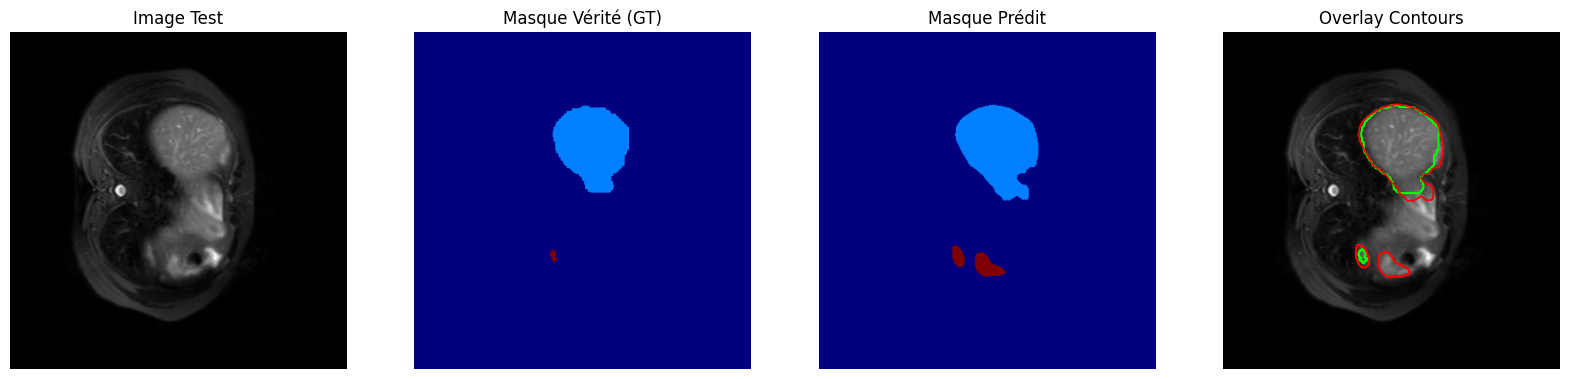

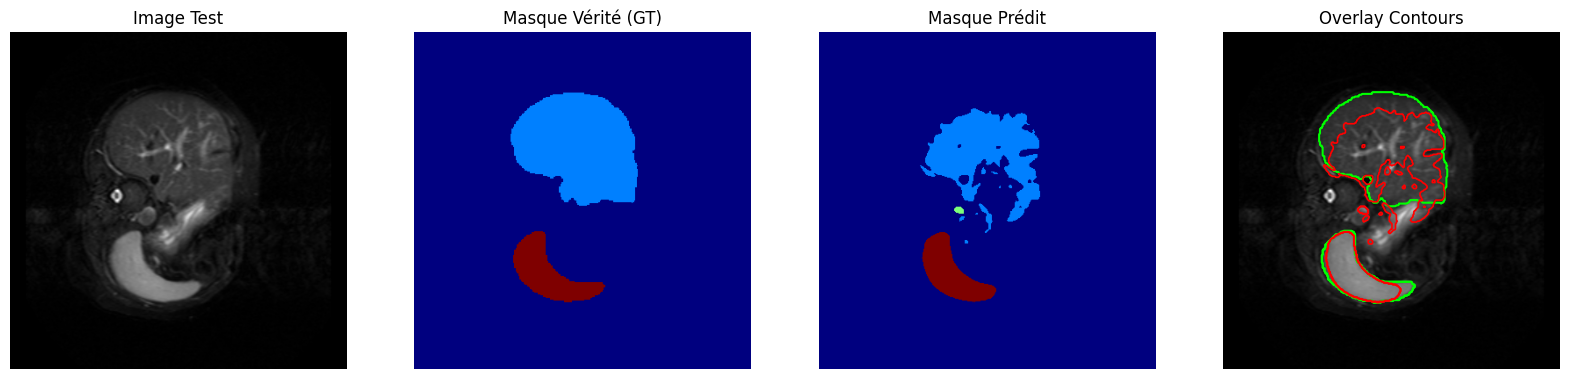

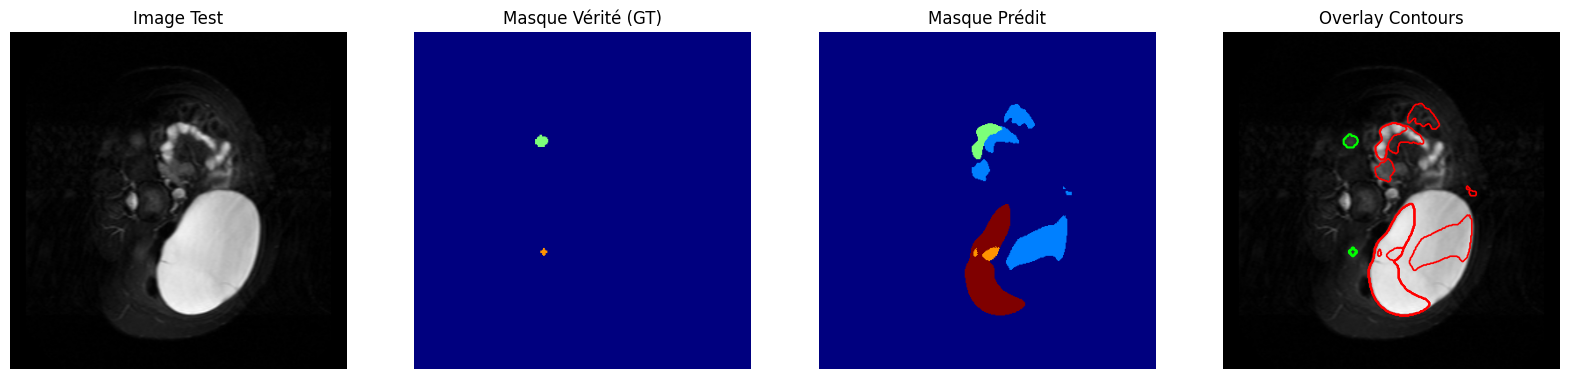

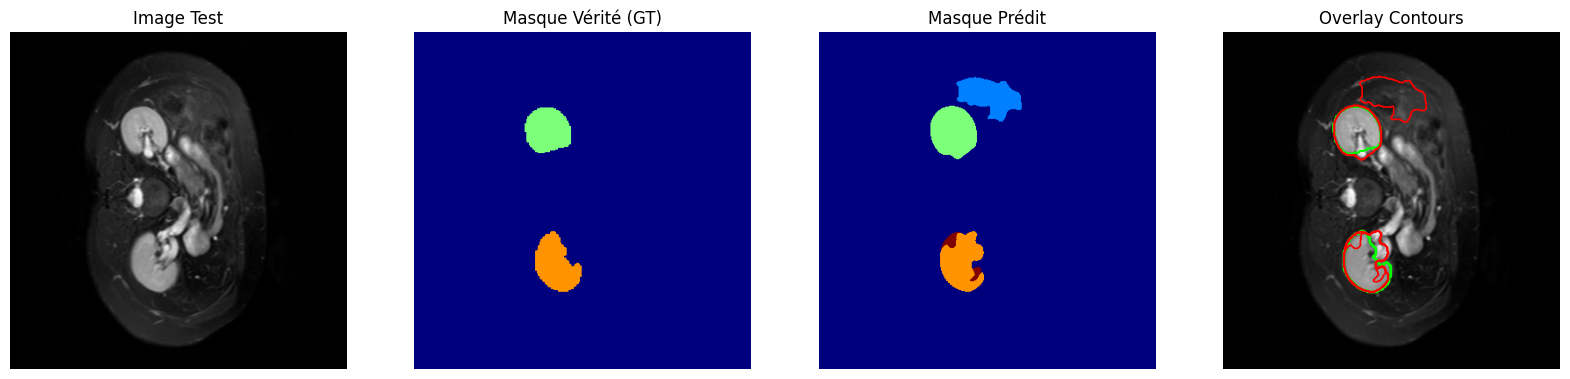

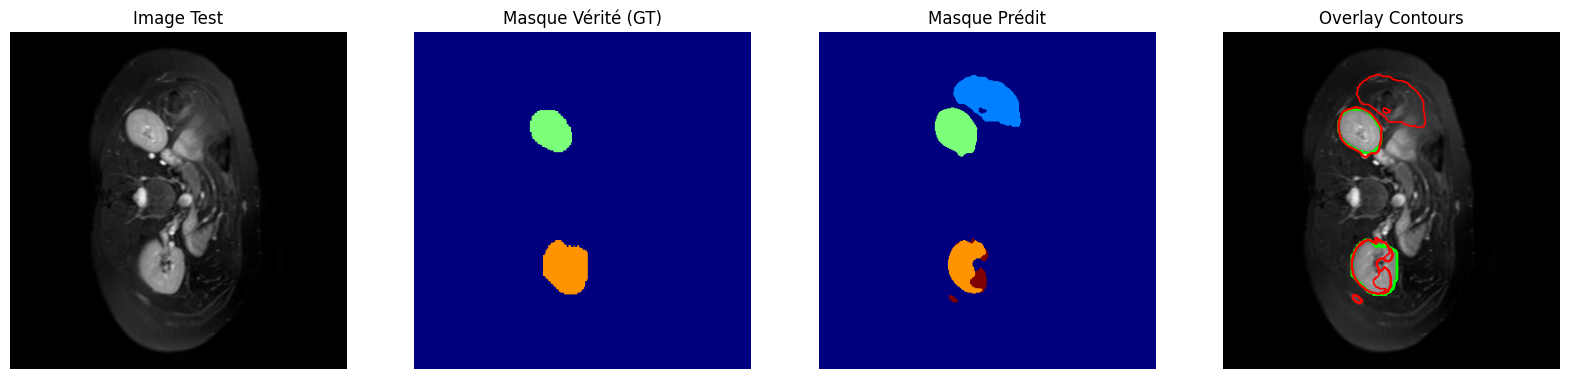


✅ Visualisation terminée pour 5 échantillons.

✅ Visualisations sauvegardées dans le dossier 'visualizations_unet_attention'.


In [14]:
# Ce module visualise les prédictions du modèle de segmentation
# sur des échantillons du jeu de test.
# ==============================================================================


# ----------------------------------------------------------------------
# 1. FONCTION DE VISUALISATION
# ----------------------------------------------------------------------
def visualize_predictions(model, test_loader, n=5, num_classes=5):
    model.eval()
    device = next(model.parameters()).device

    # Récupération de n batches aléatoires
    samples = []
    loader_list = list(test_loader)

    for _ in range(n):
        batch_inputs, batch_targets = random.choice(loader_list)
        samples.append((batch_inputs, batch_targets))

    # Boucle d'affichage
    for batch_inputs, batch_targets in samples:
        batch_inputs = batch_inputs.to(device)
        batch_targets = batch_targets.to(device)

        with torch.no_grad():
            outputs = model(batch_inputs)
            preds = torch.argmax(outputs, dim=1)

        # On affiche seulement le premier élément du batch
        img = batch_inputs[0, 0].cpu().numpy()
        gt = batch_targets[0].cpu().numpy()
        pr = preds[0].cpu().numpy()

        # Affichage
        plt.figure(figsize=(20, 6))

        # 1 – Image originale
        plt.subplot(1, 4, 1)
        plt.imshow(img, cmap="gray")
        plt.title("Image Test")
        plt.axis("off")

        # 2 – Masque GT
        plt.subplot(1, 4, 2)
        plt.imshow(gt, cmap="jet", vmin=0, vmax=num_classes-1)
        plt.title("Masque Vérité (GT)")
        plt.axis("off")

        # 3 – Masque Prédit
        plt.subplot(1, 4, 3)
        plt.imshow(pr, cmap="jet", vmin=0, vmax=num_classes-1)
        plt.title("Masque Prédit")
        plt.axis("off")

        # 4 – Overlay contours
        plt.subplot(1, 4, 4)
        plt.imshow(img, cmap="gray")
        plt.title("Overlay Contours")
        plt.axis("off")

        # Contours GT (vert)
        plt.contour(gt, levels=np.unique(gt), colors='lime', linewidths=1.5)
        # Contours prédictions (rouge)
        plt.contour(pr, levels=np.unique(pr), colors='red', linewidths=1.2)

        plt.show()

    print(f"\n✅ Visualisation terminée pour {n} échantillons.")


# Lancement de la visualisation
visualize_predictions(unet_model_pt, test_loader, n=5, num_classes=5)


# enregistrement des figures
def save_visualizations(model, test_loader, n=5, num_classes=5, output_dir="visualizations_unet_attention"):
    os.makedirs(output_dir, exist_ok=True)
    model.eval()
    device = next(model.parameters()).device
    loader_list = list(test_loader)
    for i in range(n):
        batch_inputs, batch_targets = random.choice(loader_list)
        batch_inputs = batch_inputs.to(device)
        batch_targets = batch_targets.to(device)

        with torch.no_grad():
            outputs = model(batch_inputs)
            preds = torch.argmax(outputs, dim=1)

        img = batch_inputs[0, 0].cpu().numpy()
        gt = batch_targets[0].cpu().numpy()
        pr = preds[0].cpu().numpy()

        plt.figure(figsize=(20, 6))

        plt.subplot(1, 4, 1)
        plt.imshow(img, cmap="gray")
        plt.title("Image Test")
        plt.axis("off")

        plt.subplot(1, 4, 2)
        plt.imshow(gt, cmap="jet", vmin=0, vmax=num_classes-1)
        plt.title("Masque Vérité (GT)")
        plt.axis("off")

        plt.subplot(1, 4, 3)
        plt.imshow(pr, cmap="jet", vmin=0, vmax=num_classes-1)
        plt.title("Masque Prédit")
        plt.axis("off")

        plt.subplot(1, 4, 4)
        plt.imshow(img, cmap="gray")
        plt.title("Overlay Contours")
        plt.axis("off")

        plt.contour(gt, levels=np.unique(gt), colors='lime', linewidths=1.5)
        plt.contour(pr, levels=np.unique(pr), colors='red', linewidths=1.2)

        plt.savefig(os.path.join(output_dir, f"visualization_{i+1}.png"))
        plt.close()

    print(f"\n✅ Visualisations sauvegardées dans le dossier '{output_dir}'.")

save_visualizations(unet_model_pt, test_loader, n=5, num_classes=5, output_dir="visualizations_unet_attention")

## 7.2 Plot of Train and Validation Loss

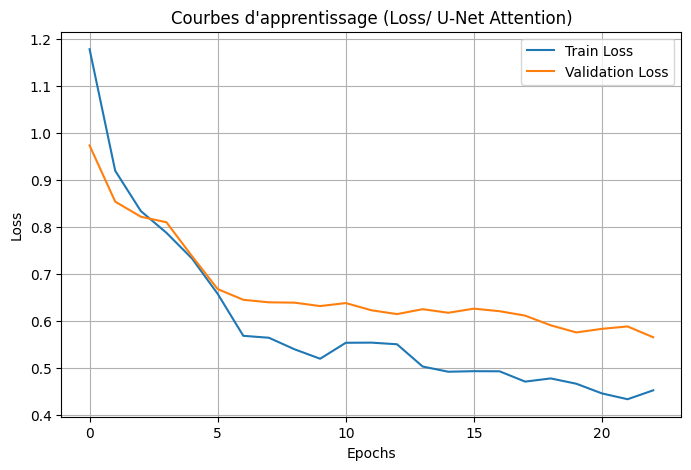

In [14]:
# Ce module trace les courbes d'apprentissage (loss, val) pour l'entraînement
# du modèle de segmentation d'images.
# ==============================================================================


# Chargement des pertes depuis le checkpoint sauvegardé
load_path = "unet_best_model_attention.pth"
ckpt = torch.load(load_path, map_location=DEVICE, weights_only=False)
train_losses = ckpt["train_losses"]
val_losses = ckpt["val_losses"]

# Tracé des courbes d'apprentissage
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Courbes d'apprentissage (Loss/ U-Net Attention)")
plt.legend()
plt.grid(True)
plt.savefig("learning_curves_unet_attention.png")
plt.show()


## 7.3 Visualization Dice per Classes

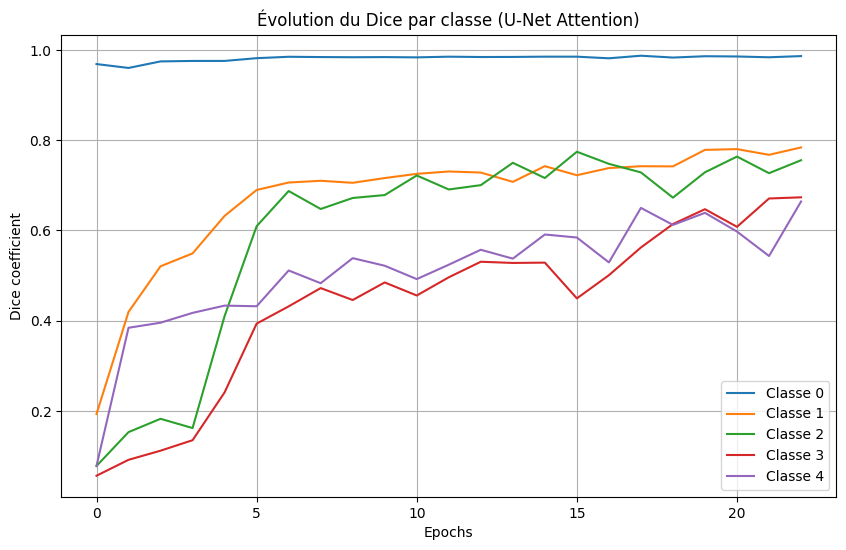

In [15]:
# Ce module visualise l'évolution du Dice par classe au cours de l'entraînement.
# ==============================================================================


# Chargement de l'historique du Dice depuis le checkpoint sauvegardé
load_path = "unet_best_model_attention.pth"
ckpt = torch.load(load_path, map_location=DEVICE, weights_only=False)
dice_history = ckpt["dice_history"]

# Tracé de l'évolution du Dice par classe
dice_history = np.array(dice_history)   # shape = (epochs, num_classes)

plt.figure(figsize=(10,6))
for c in range(NUM_CLASSES):
    plt.plot(dice_history[:,c], label=f"Classe {c}")
plt.xlabel("Epochs")
plt.ylabel("Dice coefficient")
plt.title("Évolution du Dice par classe (U-Net Attention)")
plt.legend()
plt.grid(True)
plt.savefig("dice_evolution_unet_attention.png")
plt.show()

## 7.4 Plot of the confusion Matrix

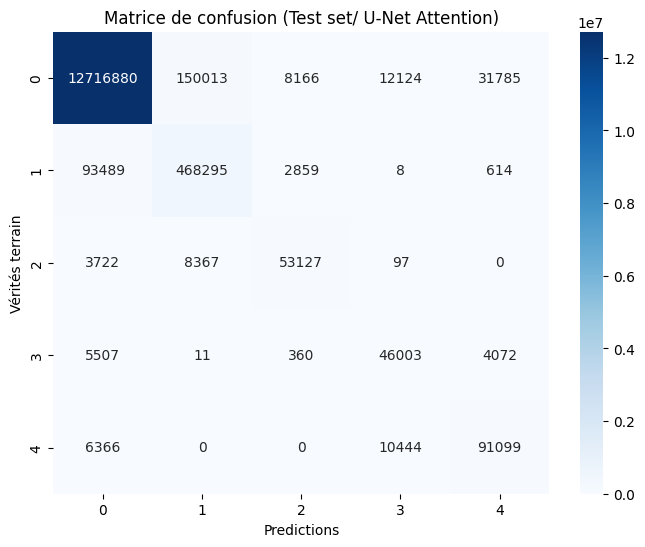

In [16]:
# Ce module trace la matrice de confusion pour les prédictions
# du modèle de segmentation d'images sur le jeu de test.
# ==============================================================================


# Collecte des prédictions et vérités terrain
all_preds = []
all_targets = []

# Boucle sur le DataLoader de test
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = unet_model_pt(x)
        preds = torch.argmax(out, dim=1)

        all_preds.append(preds.cpu().numpy().flatten())
        all_targets.append(y.cpu().numpy().flatten())

# Concatenation des résultats
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

# Calcul de la matrice de confusion
cm = confusion_matrix(all_targets, all_preds, labels=[0,1,2,3,4])

# Visualisation de la matrice de confusion
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predictions")
plt.ylabel("Vérités terrain")
plt.title("Matrice de confusion (Test set/ U-Net Attention)")
plt.savefig("confusion_matrix_unet_attention.png")
plt.show()

## 7.5 Comparison of Unet and Attention Unet

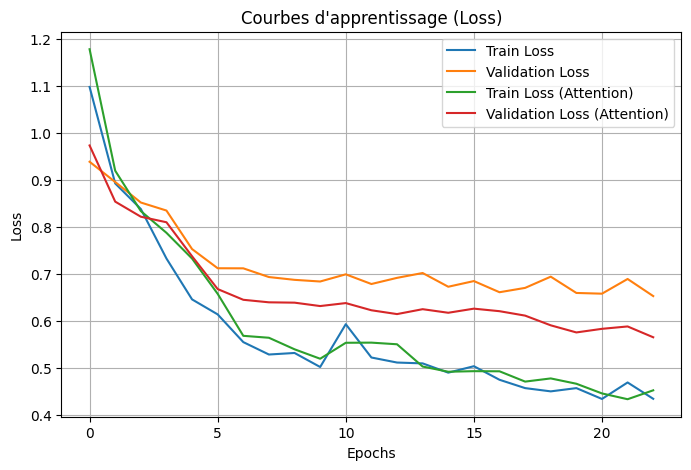

In [19]:
# Ce module compare les performances de deux modèles U-Net
# avec et sans mécanisme d'attention.
# ==============================================================================


# Chargement des pertes depuis le checkpoint sauvegardé
load_path = "unet_best_model.pth"
ckpt = torch.load(load_path, map_location=DEVICE, weights_only=False)
train_losses = ckpt["train_losses"]
val_losses = ckpt["val_losses"]

load_path_2 = "unet_best_model_attention.pth"
ckpt = torch.load(load_path_2, map_location=DEVICE, weights_only=False)
train_losses_2 = ckpt["train_losses"]
val_losses_2 = ckpt["val_losses"]

# Tracé des courbes d'apprentissage
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.plot(train_losses_2, label="Train Loss (Attention)")
plt.plot(val_losses_2, label="Validation Loss (Attention)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Courbes d'apprentissage (Loss)")
plt.legend()
plt.grid(True)
plt.savefig("learning_curves_comparison_unet_attention.png")
plt.show()

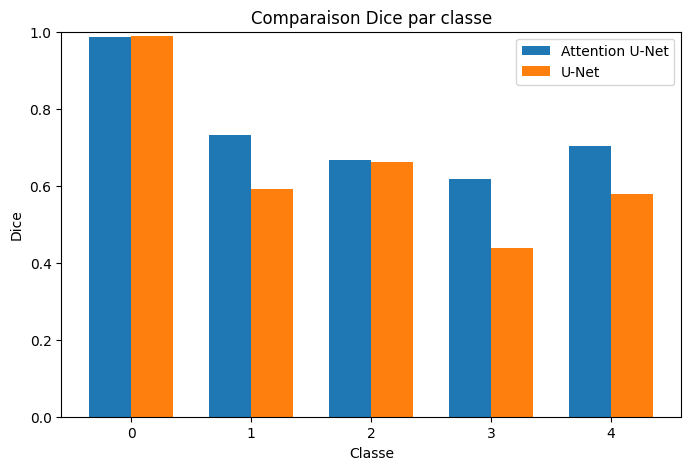

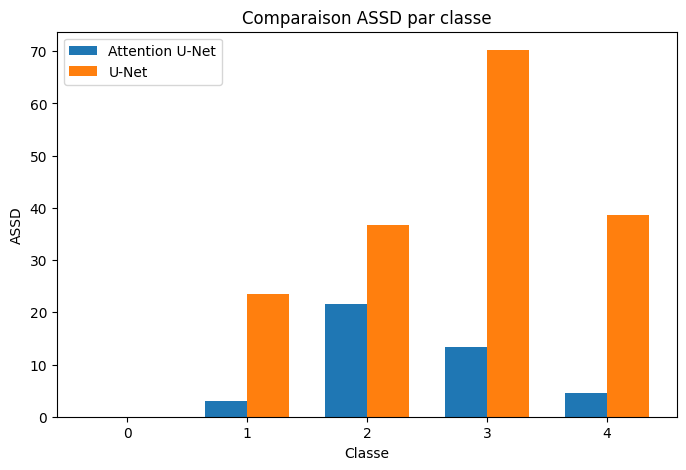

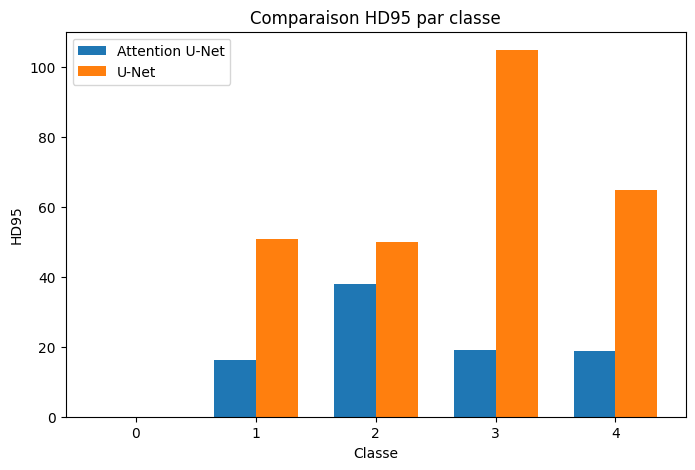

In [22]:
# Ce module compare les performances de tests de deux modèles U-Net
# avec et sans mécanisme d'attention.
# ==============================================================================


# Chemins des deux fichiers à comparer
file_A = "test_evaluation_metrics_unet_attention.txt"
file_B = "test_evaluation_metrics_unet.txt"

def extract_metrics(path):
    with open(path, "r") as f:
        text = f.read()

    dice = list(map(float, re.findall(r"Classe \d+: (\d+\.\d+)", text.split("ASSD")[0])))
    assd = list(map(float, re.findall(r"Classe \d+: (\d+\.\d+)", text.split("ASSD")[1].split("HD95")[0])))
    hd95 = list(map(float, re.findall(r"Classe \d+: (\d+\.\d+)", text.split("HD95")[1])))

    return dice, assd, hd95

# Lecture des deux fichiers
dice_A, assd_A, hd95_A = extract_metrics(file_A)
dice_B, assd_B, hd95_B = extract_metrics(file_B)

num_classes = len(dice_A)
classes = np.arange(num_classes)
bar_width = 0.35

# 1. Graphique comparatif DICE
plt.figure(figsize=(8,5))
plt.bar(classes - bar_width/2, dice_A, width=bar_width, label="Attention U-Net")
plt.bar(classes + bar_width/2, dice_B, width=bar_width, label="U-Net")
plt.title("Comparaison Dice par classe")
plt.xlabel("Classe")
plt.ylabel("Dice")
plt.legend()
plt.xticks(classes)
plt.ylim(0, 1)
plt.savefig("comparison_dice_per_class.png")
plt.show()

# 2. Graphique comparatif ASSD
plt.figure(figsize=(8,5))
plt.bar(classes - bar_width/2, assd_A, width=bar_width, label="Attention U-Net")
plt.bar(classes + bar_width/2, assd_B, width=bar_width, label="U-Net")
plt.title("Comparaison ASSD par classe")
plt.xlabel("Classe")
plt.ylabel("ASSD")
plt.legend()
plt.xticks(classes)
plt.savefig("comparison_assd_per_class.png")
plt.show()

# 3. Graphique comparatif HD95
plt.figure(figsize=(8,5))
plt.bar(classes - bar_width/2, hd95_A, width=bar_width, label="Attention U-Net")
plt.bar(classes + bar_width/2, hd95_B, width=bar_width, label="U-Net")
plt.title("Comparaison HD95 par classe")
plt.xlabel("Classe")
plt.ylabel("HD95")
plt.legend()
plt.xticks(classes)
plt.savefig("comparison_hd95_per_class.png")
plt.show()
